# Testing Clustering Pipeline

In [1]:
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import kymatio as km
from  matplotlib import pyplot as plt

sys.path.append("..")

from lib.clustering.uspec import USPEC
from lib.clustering.utils import compute_clustering_metrics
from lib.data.data_loading import ClassificationDataset
from lib.data.data_processing import convert_images_to_scat
from lib.projections.POC import POC
from lib.scattering.scattering_methods import scattering_layer
from lib.utils.arguments import process_clustering_arguments
from lib.utils.utils import create_directory
from CONFIG import CONFIG

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# macros and global variables
STANDARIZE = True  # standarizing features to hvae zero-mean and unit-variance
MAX_DIMS = 10  # maximum nubmer of directions to consider
STEP = 1  # step for considering distances (e.g., [20, 40, 60, ...])
DATASET = "fashion_mnist"  # dataset used for classification ['mnist', 'svhn']
N_IMGS_TEST = 5000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_PATH = os.path.join(ROOT_PATH, CONFIG["paths"]["data_path"])

## Loading Dataset and Computing Scat

In [4]:
dataset = ClassificationDataset(data_path=CONFIG["paths"]["data_path"],
                                dataset_name=DATASET,
                                valid_size=0)
imgs, labels = dataset.get_all_data()
if(N_IMGS_TEST > 0):
    imgs, labels = imgs[:N_IMGS_TEST, :], labels[:N_IMGS_TEST]

In [5]:
scattering_net, _ = scattering_layer()
scattering_net = scattering_net.cuda() if DEVICE.type == 'cuda' else scattering_net
scat_features  = convert_images_to_scat(imgs, scattering=scattering_net,
                                        device=DEVICE, equalize=STANDARIZE,
                                        batch_size=64)
n_labels = len(np.unique(labels))

100%|██████████| 79/79 [00:09<00:00,  8.29it/s]


## POC Preprocessing: Optimizing Num Dims

In [6]:
poc = POC()
poc.fit(data=scat_features)

uspec = USPEC(p_interm=4000, p_final=1000,
              n_neighbors=5, num_clusters=10, num_iters=100)

dim_candidates = np.arange(0, MAX_DIMS, STEP)

In [7]:
# computing projections for each candidate
acc, nmi, ari = [], [], []
for i, cand_dim in enumerate(dim_candidates):
    print(f"Iteration {i+1}/{len(dim_candidates)}")
    proj_data = poc.transform(data=scat_features, n_dims=cand_dim)
    preds = uspec.cluster(data=proj_data, verbose=1)
    cur_ari, cur_acc, cur_nmi = compute_clustering_metrics(preds=preds, labels=labels)
    acc.append(cur_acc)
    nmi.append(cur_nmi)
    ari.append(cur_ari)

Iteration 1/10
Starting clustering:
  Sampling time: 24.88 seconds
  Computing affinity time: 4.26 seconds
  Transfer cut time: 4.36 seconds
Iteration 2/10
Starting clustering:
  Sampling time: 23.66 seconds
  Computing affinity time: 16.47 seconds
  Transfer cut time: 1.92 seconds
Iteration 3/10
Starting clustering:
  Sampling time: 25.13 seconds
  Computing affinity time: 16.43 seconds
  Transfer cut time: 1.7 seconds
Iteration 4/10
Starting clustering:
  Sampling time: 25.56 seconds
  Computing affinity time: 15.92 seconds
  Transfer cut time: 1.81 seconds
Iteration 5/10
Starting clustering:
  Sampling time: 23.96 seconds
  Computing affinity time: 5.29 seconds
  Transfer cut time: 1.04 seconds
Iteration 6/10
Starting clustering:
  Sampling time: 27.22 seconds
  Computing affinity time: 16.55 seconds
  Transfer cut time: 1.07 seconds
Iteration 7/10
Starting clustering:
  Sampling time: 23.56 seconds
  Computing affinity time: 16.55 seconds
  Transfer cut time: 1.05 seconds
Iteration

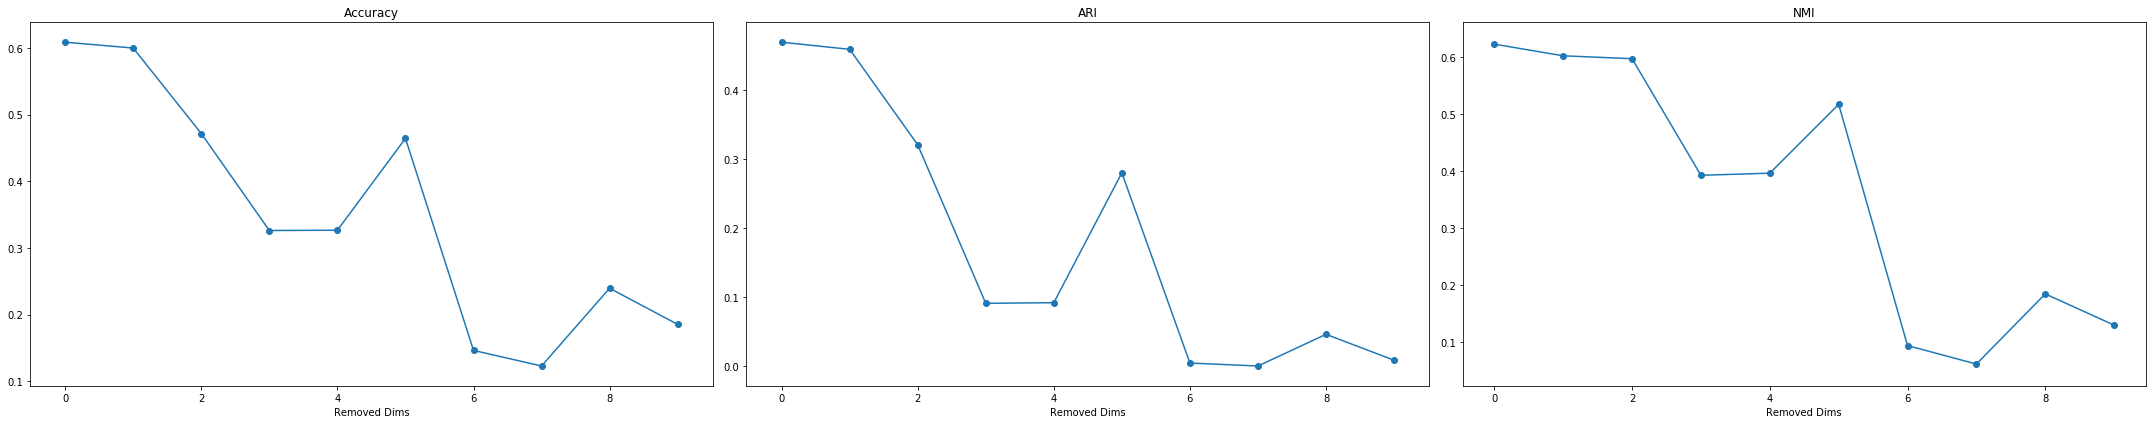

In [13]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(30, 6)

ax[0].plot(dim_candidates, acc)
ax[0].scatter(dim_candidates, acc)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Removed Dims")

ax[1].plot(dim_candidates, ari)
ax[1].scatter(dim_candidates, ari)
ax[1].set_title("ARI")
ax[1].set_xlabel("Removed Dims")

ax[2].scatter(dim_candidates, nmi)
ax[2].plot(dim_candidates, nmi)
ax[2].set_title("NMI")
ax[2].set_xlabel("Removed Dims")

plt.tight_layout()
# plt.show()
plt.save

In [14]:
opt_idx = np.argmax(acc)
opt_dims = dim_candidates[opt_idx]

print(f"Best Dims are {opt_dims} with an accuracy of {np.max(acc)}.")

Best Dims are 0 with an accuracy of 0.6086.
